# Classifying NL levels from food purchase data

In [1]:
import numpy as np
import pandas as pd
import datetime
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.utils import class_weight

from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import ComplementNB

from sklearn.preprocessing import OneHotEncoder

from imblearn.over_sampling import RandomOverSampler
from collections import Counter

import pickle

In [2]:
## helper functions

df_DR = pd.DataFrame()

# nutrient per 1000 kcal
def calc_kcal_adjusted_intake(df_name_in, groupby_col = "r2n_user"):
    df_name_in = df_name_in.copy(deep=True)
    subset_list = ["totalFat_actual_quantity","saturatedFat_actual_quantity","totalCarbohydrate_actual_quantity","sugars_actual_quantity","sodium_actual_quantity", "protein_actual_quantity","dietaryFiber_actual_quantity"]
    df_output = pd.DataFrame()
    kcal_total = df_name_in.groupby(groupby_col)["actual_kcal"].sum()
   
    for col in subset_list:
        df_output[col.replace("_actual_quantity", "_per_KCAL")] = df_name_in.groupby(groupby_col)[col].sum() / kcal_total * 1000

    return df_output


def create_food_profiles(input_df = df_DR, group_by = "r2n_user", sum_by_measure ="actual_kcal", major_or_minor = "major"):
    input_df = input_df.copy(deep=True)
    
    measure_per_fg = input_df.groupby([group_by, major_or_minor])[sum_by_measure].sum()
    measure_total = measure_per_fg.groupby([group_by]).sum()

    df_fg_per_measure = pd.DataFrame()
    df_fg_per_measure = measure_per_fg / measure_total * 1000 #per 1000 kcal
    df_fg_per_measure = df_fg_per_measure.reset_index()

    df_fg_per_measure = df_fg_per_measure.pivot(index=group_by, columns=major_or_minor, values=sum_by_measure).fillna(0)
    df_fg_per_measure = df_fg_per_measure.dropna() #just to be safe

    if group_by == "r2n_user": #enable choosing by user or by basket in the function parameters
        # adding outcomes
        df_fg_per_measure = pd.merge(my_matching_list, df_fg_per_measure, how="right", left_on=['user_hash'], right_index=True).reset_index()
        df_fg_per_measure.drop(['index', "bitsAboutMeToken","user_hash", "external_id", "bam_id"], inplace=True, axis=1)
        #remove users that did not complete the survey but just joined BAM
        df_fg_per_measure = df_fg_per_measure[df_fg_per_measure['relative_NL_level'].notna()].reset_index()
        #onehot encode outcomes
        df_fg_per_measure['relative_NL_level'] = pd.get_dummies(df_fg_per_measure['relative_NL_level'])["high"] # use only one dummy column
    else:
        # add outcomes
        df_fg_per_measure = pd.merge(df_fg_per_measure, basket_outcomes, how = "left", on = "basket_id")
        #remove baskets with no outcomes
        df_fg_per_measure.dropna(inplace=True)
        #onehot encode outcomes
        df_fg_per_measure['relative_NL_level'] = pd.get_dummies(df_fg_per_measure['relative_NL_level'])["high"]  # use only one dummy column

    return df_fg_per_measure

def print_no_baskets(df_in):
    print("Number of baskets: " + str(df_in['basket_id'].nunique() ))

***
#### Data Import & Preparation

In [3]:
# import DR data

df_DR = pd.read_csv("../data/receipts_nutr_matched_MBL_clean.csv")

#filter out rows without serving size info
df_DR.dropna(subset=['serving_size'], inplace=True)
df_DR = df_DR[df_DR['serving_size']!=0]

df_DR

,r2n_user,receipttype,business_unit,article_id,gtin,quantity_unit,quantity,price,discount,real_price,...,saturatedFat_actual_quantity,saturatedFat_actual_kcal,totalCarbohydrate_actual_quantity,totalCarbohydrate_actual_kcal,sugars_actual_quantity,sugars_actual_kcal,protein_actual_quantity,protein_actual_kcal,amount_s_sizes,dietaryFiber_actual_quantity
0,e023cc56e306daa6c52457bd8c26a68f,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.000,2.95,0.0,2.95,...,9.54,85.86,3.180,12.720,1.590,6.360,41.34,165.36,6.0,0.0
1,08b1325c816ce26691157c2e195f47e8,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.000,3.20,0.0,3.20,...,9.54,85.86,3.180,12.720,1.590,6.360,41.34,165.36,6.0,0.0
2,ad2b13a3cf56cd3408ce586dc679c6f9,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.000,3.20,0.0,3.20,...,9.54,85.86,3.180,12.720,1.590,6.360,41.34,165.36,6.0,0.0
3,ad2b13a3cf56cd3408ce586dc679c6f9,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.000,3.20,0.0,3.20,...,9.54,85.86,3.180,12.720,1.590,6.360,41.34,165.36,6.0,0.0
4,ad2b13a3cf56cd3408ce586dc679c6f9,json,migros,Eier Freiland 6x53g+,7610200313737,units,1.000,3.20,0.0,3.20,...,9.54,85.86,3.180,12.720,1.590,6.360,41.34,165.36,6.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16834,9918864007698824bf0122ab80374db4,json,coop,Cicorino Trevisana offen,7610845857351,kg,0.303,1.50,0.0,1.50,...,0.00,0.00,2.121,8.484,1.818,7.272,3.03,12.12,10.0,25.0
16835,9918864007698824bf0122ab80374db4,json,coop,Graubünden Vollmilch past. 1L,7610829553477,units,1.000,1.80,0.0,1.80,...,21.00,189.00,49.000,196.000,49.000,196.000,32.00,128.00,4.0,0.0
16836,9918864007698824bf0122ab80374db4,json,coop,Graubünden Vollmilch past. 1L,7610829553477,units,1.000,1.80,0.0,1.80,...,21.00,189.00,49.000,196.000,49.000,196.000,32.00,128.00,4.0,0.0
16837,9918864007698824bf0122ab80374db4,json,coop,Graubünden Vollmilch past. 1L,7610829553477,units,1.000,1.80,0.0,1.80,...,21.00,189.00,49.000,196.000,49.000,196.000,32.00,128.00,4.0,0.0


***

### User-focused data
#### Macronutrient profiles

In [4]:
### Getting outcomes

my_matching_list = pd.read_csv("../data/matching_list_incl_outcomes2.csv", index_col=0) #generated in NB3

my_matching_list

,bam_id,external_id,user_hash,relative_NL_level,bitsAboutMeToken,diabetes_detail
0,1b775983-395f-4ab0-8c12-76d009fdf150,pvf9usgp,NaN,NaN,NaN,NaN
1,920054a7-4549-4d30-b30a-176477e4d98b,dyeee0pr,NaN,NaN,NaN,NaN
2,e1043932-9378-4a03-8c9e-bfebdcbe66a6,2xkesqby,NaN,NaN,NaN,NaN
3,223a4af2-936a-43b9-a721-57a64ea2c0b8,76lefd75,NaN,NaN,NaN,NaN
4,a6f3b760-a7ce-4f3c-8267-d1e159c00952,6irna0pf,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
56,b0316759-8e72-40dd-81ca-ef0380d0fcea,441fti0g,NaN,high,441fti0g,none
57,b2cb3243-a0c6-4de9-9579-1074fe4aec87,wtv3dlhu,NaN,high,wtv3dlhu,none
58,47d2f953-0dcc-49c4-be98-3f224ddfab90,custom_001,b150561d2dad1bb7b5e7db1e1846c185,high,custom_001,none
59,81e23e56-c2ec-41e0-acb7-a5721f50c42a,custom_002,9e7ebb2222b6eda6177412728ff1b37b,high,custom_002,none


In [5]:
# DP-Type 1: create macronutrient profile PER USER
# Note: This was not used in the final training, as there were too few participants for a meaningful sample size.


# Summarise macro nutrients share per 1000 bought KCAL (totalfat, saturated fat, carbs, sugars, sodium, protein, fiber)

# get one column for each macronutrient, showing percentage per calorie bought
macros_names = ['totalFat', 'saturatedFat', 'totalCarbohydrate', 'sugars', 'sodium', 'protein', 'dietaryFiber']
#yielding share of macro per 1000 kcal bought
for macro in macros_names:
    df_DR[f"{macro}_per_KCAL"] = (np.nan_to_num(df_DR[f"{macro}"] / df_DR["energyKcal"] )) # by using nan_to_num we fix NAN error when 0's are present

df_DR_nutrient_per_user = calc_kcal_adjusted_intake(df_DR, groupby_col = "r2n_user")

# adding outcomes
df_DR_nutrient_per_user = pd.merge(my_matching_list, df_DR_nutrient_per_user, how="right", left_on=['user_hash'], right_index=True).reset_index()
df_DR_nutrient_per_user.drop(['index', "bitsAboutMeToken","user_hash", "external_id", "bam_id"], inplace=True, axis=1)

#remove users that did not complete the survey but just joined BAM or otherwise no information
df_DR_nutrient_per_user = df_DR_nutrient_per_user[df_DR_nutrient_per_user['relative_NL_level'].notna()]

#onehot encode outcomes
df_DR_nutrient_per_user['relative_NL_level'] = df_DR_nutrient_per_user['relative_NL_level'].map({'high': 1, 'medium': 0, "low": 0})

df_DR_nutrient_per_user

,relative_NL_level,diabetes_detail,totalFat_per_KCAL,saturatedFat_per_KCAL,totalCarbohydrate_per_KCAL,sugars_per_KCAL,sodium_per_KCAL,protein_per_KCAL,dietaryFiber_per_KCAL
0,0,none,53.668268,23.119910,94.464996,41.995448,1.621664,34.770442,17.335523
2,1,none,48.006602,19.838241,106.438249,32.296696,3.490859,35.530101,8.877835
3,1,none,55.367393,27.269790,91.399276,46.603276,7.193711,34.024089,13.307712
5,0,none,57.518559,28.867420,88.511138,28.729380,0.740267,32.072105,12.173502
6,0,none,48.441050,22.326744,105.545304,38.897249,1.021005,35.394365,10.858682
10,1,none,37.978252,19.203223,125.406492,64.422966,1.118440,39.118955,18.034657
11,1,none,25.497100,11.145748,145.810791,86.191017,1.955419,46.793807,20.885005
13,1,none,44.020342,20.599915,111.759575,49.278442,3.387796,39.194656,12.429445
14,1,none,55.358866,21.236860,95.931378,53.637333,4.475093,29.280663,8.804211
15,1,none,36.609870,14.198265,125.787777,52.858000,1.015112,41.619476,22.712605


#### Food group profiles

In [6]:
# DP-Type 2: create food group profiles PER USER

df_majorfg_per_kcal = create_food_profiles(input_df = df_DR, group_by = "r2n_user", sum_by_measure="actual_kcal", major_or_minor="major")

df_minorfg_per_kcal = create_food_profiles(input_df = df_DR, group_by = "r2n_user", sum_by_measure="actual_kcal", major_or_minor="minor")

df_minorfg_per_kcal

,index,relative_NL_level,diabetes_detail,Asian dishes,Avocado,Baby food,Baking ingredients,Bars,Beef,Breads and rolls,...,"Sweets, fruit and chewing gum",Syrup,Tea,Tofu,Veal,Vegetables cooked (incl. cans),Vegetarian meat alternatives,Water-based ice,Yeast,Yogurt and sour milk
0,0,0,none,0.000000,11.556919,0.00000,6.585748,2.854021,7.215359,40.725180,...,0.000000,0.000000,0.0,0.246006,0.246576,10.112218,0.000000,0.000000,0.306775,8.147664
1,2,1,none,0.000000,4.705103,0.00000,2.054272,3.974102,10.530842,90.777750,...,0.000000,0.594397,0.0,0.579267,0.439962,11.373300,0.855932,0.000000,0.000000,26.847120
2,3,1,none,0.000000,9.609963,0.00000,0.496020,1.226746,3.297878,84.420412,...,0.000000,0.223478,0.0,1.039214,0.000000,3.481363,13.961730,0.000000,0.336952,28.280606
3,5,0,none,0.000000,5.073528,0.00000,0.000000,0.000000,11.375014,49.055658,...,0.000000,0.000000,0.0,0.000000,0.000000,2.488436,19.415405,0.000000,0.000000,4.232731
4,6,0,none,0.000000,6.835809,0.00000,0.182770,17.178667,0.000000,49.758740,...,11.902298,0.359012,0.0,0.526551,0.000000,17.270242,3.605298,0.000000,5.413048,4.801842
5,10,1,none,0.184028,5.103266,0.00000,0.000000,0.849340,4.685825,62.095634,...,2.357188,0.000000,0.0,1.749278,0.000000,1.061277,0.000000,1.622058,0.599431,69.632547
6,11,1,none,0.302711,0.184236,1.96258,5.490072,0.124425,1.512904,8.979712,...,46.327077,0.215290,0.0,1.795912,0.000000,4.522204,0.941080,0.000000,2.488650,27.333633
7,13,1,none,0.000000,5.899624,0.00000,0.492974,26.171784,16.696135,133.331256,...,0.609209,1.779106,0.0,0.000000,0.903390,4.617778,0.000000,0.000000,0.894156,27.605096
8,14,1,none,0.000000,0.000000,0.00000,19.494337,0.000000,0.000000,39.836695,...,3.609022,0.000000,0.0,4.132110,1.378451,3.846106,0.000000,0.000000,0.000000,24.819806
9,15,1,none,0.353406,26.297351,0.00000,0.000000,1.139199,2.677556,90.384576,...,1.956025,0.000000,0.0,2.931285,0.000000,32.711956,10.884021,0.000000,1.534853,41.284245


***

### Basket-Focused Data
#### Macronutrients profiles

In [7]:
# transform DR data into individual BASKETS - Preprocessing
df_DR_baskets = df_DR.copy()

#add an ID per basket (based on user & date)
df_DR_baskets["basket_id"] = df_DR_baskets.groupby(["r2n_user", "receipt_datetime"]).ngroup()

#drop any rows where actual_kcal == 0 to avoid error
df_DR_baskets = df_DR_baskets[df_DR_baskets["actual_kcal"]>0] 
#fix inf error when dividing by 0
df_DR_baskets.loc[~np.isfinite(df_DR_baskets['sodium_per_KCAL']), 'sodium_per_KCAL'] = 0

# Drop any baskets with less than or equal to x items in them
basket_threshold = 5
keep = df_DR_baskets.groupby("basket_id")["basket_id"].transform("count") >= basket_threshold
df_DR_baskets = df_DR_baskets.loc[keep]

df_DR_baskets.shape #Note: The un-matched baskets are here not filtered out, yet. size will reduce further later

(14723, 51)

In [8]:
### Experiment 1: Not one basket per time, but all items purchased during 1 month ("monthly baskets")

df_DR_baskets_1month = df_DR.copy()

# focus on month (by dropping day info from datetime)
df_DR_baskets_1month['receipt_datetime'] = [x[:-3] for x in df_DR_baskets_1month['receipt_datetime']]

#add an ID per basket (based on user & date)
df_DR_baskets_1month["basket_id"] = df_DR_baskets_1month.groupby(["r2n_user", "receipt_datetime"]).ngroup()

#drop any rows where actual_kcal == 0 to avoid error
df_DR_baskets_1month = df_DR_baskets_1month[df_DR_baskets_1month["actual_kcal"]>0] 
#fix inf error when dividing by 0
df_DR_baskets_1month.loc[~np.isfinite(df_DR_baskets_1month['sodium_per_KCAL']), 'sodium_per_KCAL'] = 0

# Drop any baskets with less than or equal to x items in them
basket_threshold = 5
keep = df_DR_baskets_1month.groupby("basket_id")["basket_id"].transform("count") >= basket_threshold
df_DR_baskets_1month = df_DR_baskets_1month.loc[keep]

df_DR_baskets_1month.shape #This has probably more records than the standard approach, because due to the monthly bundling of baskets they are more likely to exceed the threshold of 5 items

(15900, 51)

In [9]:
### Experiment 2: Not one basket per time, but all items purchased during a quarter ("quarterly baskets")

df_DR_baskets_quarter = df_DR.copy()

# Focusing on quarters
df_DR_baskets_quarter['receipt_datetime'] = pd.to_datetime(df_DR_baskets_quarter['receipt_datetime'], format="%Y-%m-%d")
df_DR_baskets_quarter['receipt_datetime'] = pd.PeriodIndex(df_DR_baskets_quarter['receipt_datetime'], freq='Q')

#add an ID per basket (based on user & date)
df_DR_baskets_quarter["basket_id"] = df_DR_baskets_quarter.groupby(["r2n_user", "receipt_datetime"]).ngroup()

#drop any rows where actual_kcal == 0 to avoid error
df_DR_baskets_quarter = df_DR_baskets_quarter[df_DR_baskets_quarter["actual_kcal"]>0] 
#fix inf error when dividing by 0
df_DR_baskets_quarter.loc[~np.isfinite(df_DR_baskets_quarter['sodium_per_KCAL']), 'sodium_per_KCAL'] = 0

# Drop any baskets with less than or equal to x items in them
basket_threshold = 5
keep = df_DR_baskets_quarter.groupby("basket_id")["basket_id"].transform("count") >= basket_threshold
df_DR_baskets_quarter = df_DR_baskets_quarter.loc[keep]

df_DR_baskets_quarter.shape #This has probably more records than the standard approach, because due to the monthly bundling of baskets they are more likely to exceed the threshold of 5 items

(15952, 51)

In [10]:
# Uncomment this TO SWITCH TO AGGREGATED BASKETS MODE for training (i.e., select type of data to use)

#df_DR_baskets = df_DR_baskets_1month
#df_DR_baskets = df_DR_baskets_quarter

In [11]:
# prepare outcomes to add afterwards back to basket dataframes

basket_outcomes = pd.merge(df_DR_baskets[["basket_id", "r2n_user"]], my_matching_list , how="left", left_on='r2n_user', right_on = "user_hash").reset_index()
basket_outcomes.drop(['index', "bitsAboutMeToken", "external_id", "bam_id", "r2n_user", "user_hash"], inplace=True, axis=1)
basket_outcomes = basket_outcomes.groupby('basket_id').first().reset_index()

In [12]:
# Basket Info Type 1: macro composition per 1000 kcal per basket

# get one column for each macronutrient, showing percentage per calorie bought
macros_names = ['totalFat', 'saturatedFat', 'totalCarbohydrate', 'sugars', 'sodium', 'protein', 'dietaryFiber']

#yielding share of macro per 1000 kcal bought
for macro in macros_names:
    df_DR[f"{macro}_per_KCAL"] = (np.nan_to_num(df_DR[f"{macro}"] / df_DR["energyKcal"] )) # by using nan_to_num we fix NAN error when 0's are present

df_DR_baskets_macro_comp_KCAL = calc_kcal_adjusted_intake(df_DR_baskets, groupby_col = "basket_id")

#add outcomes
df_DR_baskets_macro_comp_KCAL = pd.merge(df_DR_baskets_macro_comp_KCAL, basket_outcomes, how = "left", on = "basket_id")

#remove baskets with no outcomes
df_DR_baskets_macro_comp_KCAL.dropna(inplace=True)
df_DR_baskets_macro_comp_KCAL = df_DR_baskets_macro_comp_KCAL.reset_index(drop=True)

#onehot encode outcomes
df_DR_baskets_macro_comp_KCAL['relative_NL_level'] = pd.get_dummies(df_DR_baskets_macro_comp_KCAL['relative_NL_level'])["high"]

df_DR_baskets_macro_comp_KCAL

,basket_id,totalFat_per_KCAL,saturatedFat_per_KCAL,totalCarbohydrate_per_KCAL,sugars_per_KCAL,sodium_per_KCAL,protein_per_KCAL,dietaryFiber_per_KCAL,relative_NL_level,diabetes_detail
0,0,70.541659,31.282317,58.534520,45.166916,0.483088,32.746747,14.353618,0,none
1,1,99.458523,19.141951,17.362748,17.020943,0.335633,8.855575,12.515329,0,none
2,2,35.766790,19.246217,131.649603,112.029807,1.297385,37.875120,90.781447,0,none
3,3,25.411445,13.051289,154.183966,136.250104,0.244866,38.640283,53.665666,0,none
4,4,68.223146,37.049585,64.461217,36.589429,1.215041,32.036704,12.365976,0,none
...,...,...,...,...,...,...,...,...,...,...
784,1343,5.863666,0.000000,192.189155,172.432868,0.439105,36.794108,248.455058,1,none
785,1349,70.776444,33.453310,42.496675,1.773356,1.039066,48.256325,3.268686,1,none
786,1350,51.753623,12.517110,110.452807,71.178874,12.431311,23.101541,27.906977,1,none
787,1351,70.868582,26.245127,48.609076,32.860736,2.348854,41.936614,13.771111,1,none


In [13]:
# Just for reporting & information: Calculate basket sizes for all three approaches (single/monthly/quarterly)

df_DR_baskets_size_single = calc_kcal_adjusted_intake(df_DR_baskets, groupby_col = "basket_id")
df_DR_baskets_size_monthly = calc_kcal_adjusted_intake(df_DR_baskets_1month, groupby_col = "basket_id")
df_DR_baskets_size_quarterly= calc_kcal_adjusted_intake(df_DR_baskets_quarter, groupby_col = "basket_id")

#add outcomes
df_DR_baskets_size_single = pd.merge(df_DR_baskets_size_single, basket_outcomes, how = "left", on = "basket_id")
df_DR_baskets_size_monthly = pd.merge(df_DR_baskets_size_monthly, basket_outcomes, how = "left", on = "basket_id")
df_DR_baskets_size_quarterly = pd.merge(df_DR_baskets_size_quarterly, basket_outcomes, how = "left", on = "basket_id")

#remove baskets with no outcomes
df_DR_baskets_size_single.dropna(inplace=True)
df_DR_baskets_size_single = df_DR_baskets_size_single.reset_index(drop=True)
df_DR_baskets_size_monthly.dropna(inplace=True)
df_DR_baskets_size_monthly = df_DR_baskets_size_monthly.reset_index(drop=True)
df_DR_baskets_size_quarterly.dropna(inplace=True)
df_DR_baskets_size_quarterly = df_DR_baskets_size_quarterly.reset_index(drop=True)

print("No. of single baskets: " + str( df_DR_baskets_size_single["basket_id"].nunique()))
print("No. of monthly baskets: " + str( df_DR_baskets_size_monthly["basket_id"].nunique()))
print("No. of quarterly baskets: " + str( df_DR_baskets_size_quarterly["basket_id"].nunique()))

No. of single baskets: 789
No. of monthly baskets: 213
No. of quarterly baskets: 105


****

In [14]:
# Filtered Basket statistics

df_DR_baskets_2 = df_DR_baskets.copy()
#add outcomes
df_DR_baskets_2 = pd.merge(df_DR_baskets_2, basket_outcomes, how = "left", on = "basket_id")

#remove baskets with no outcomes
df_DR_baskets_2.dropna(inplace=True)
df_DR_baskets_2 = df_DR_baskets_2.reset_index(drop=True)

print(df_DR_baskets_2.groupby("basket_id").size().describe())

count    789.000000
mean      13.453739
std       10.220635
min        2.000000
25%        7.000000
50%       10.000000
75%       17.000000
max      109.000000
dtype: float64


#### Food group profiles

In [15]:
# Basket Info Type 2: major food group composition per basket per 1000 kcal
df_DR_baskets_maj_fg_KCAL = create_food_profiles(input_df = df_DR_baskets, group_by = "basket_id", sum_by_measure="actual_kcal", major_or_minor="major")

df_DR_baskets_maj_fg_KCAL

,basket_id,"Breads, flakes and breakfast cereals","Cereal products, legumes and potatoes",Dishes,Eggs,Fats and oils,Fish,Fruit,Meat alternatives,Meat and sausages,Milk and milkproducts,"Nuts, seeds and oil fruits",Salty snacks,Soft drinks,Special food,Sweets,Various,Vegetables,relative_NL_level,diabetes_detail
0,0,0.000000,0.000000,0.000000,34.826667,0.000000,8.259763,261.455289,0.0,8.302157,473.067674,109.192802,41.643269,35.681613,0.0,0.000000,23.437351,4.133415,0,none
1,1,0.000000,0.000000,0.000000,0.000000,783.044627,0.000000,45.562680,0.0,41.953600,101.317752,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,28.121341,0,none
2,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,397.515449,0.0,0.000000,422.106218,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,180.378333,0,none
3,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,564.254855,0.0,0.000000,435.745145,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0,none
4,4,59.272539,0.000000,0.000000,0.000000,0.000000,0.000000,135.870891,0.0,10.177800,521.482026,0.000000,97.240787,0.000000,0.0,141.066168,0.000000,34.889788,0,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,1343,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,378.805456,0.0,0.000000,0.000000,0.000000,0.000000,31.293958,0.0,0.000000,0.000000,589.900586,1,none
881,1349,0.000000,424.027472,8.791638,185.187968,0.000000,0.000000,0.000000,0.0,0.000000,380.783132,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.209790,1,none
882,1350,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214.997292,0.0,0.000000,249.462507,366.972477,0.000000,0.000000,0.0,0.000000,110.288687,58.279037,1,none
883,1351,0.000000,0.000000,262.956637,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,515.105267,134.552603,0.000000,0.000000,0.0,0.000000,0.000000,87.385493,1,none


In [16]:
df_DR_baskets_min_fg_KCAL = create_food_profiles(input_df = df_DR_baskets, group_by = "basket_id", sum_by_measure="actual_kcal", major_or_minor="minor")

df_DR_baskets_min_fg_KCAL

,basket_id,Asian dishes,Avocado,Baby food,Baking ingredients,Bars,Beef,Breads and rolls,Broth & Bouillon for Mixing,Butter and margarine,...,Syrup,Tofu,Veal,Vegetables cooked (incl. cans),Vegetarian meat alternatives,Water-based ice,Yeast,Yogurt and sour milk,relative_NL_level,diabetes_detail
0,0,0.0,24.941801,0.0,0.000000,0.0,0.0,0.000000,0.0,314.563448,...,0.0,0.0,0.0,0.000000,0.0,0.0,23.437351,0.000000,0,none
1,1,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,2.516929,0.0,0.0,0.000000,0.000000,0,none
2,2,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0,none
3,3,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0,none
4,4,0.0,0.000000,0.0,0.000000,0.0,0.0,59.272539,0.0,244.844671,...,0.0,0.0,0.0,28.584460,0.0,0.0,0.000000,0.000000,0,none
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,1343,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1,none
881,1349,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,1,none
882,1350,0.0,231.737539,0.0,110.288687,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,249.462507,1,none
883,1351,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,160.031265,1,none


In [16]:
#What is the split of high vs low NL baskets?
 
df_DR_baskets_maj_fg_KCAL["relative_NL_level"].value_counts()

1    604
0    185
Name: relative_NL_level, dtype: int64

***

## Training phase

#### Note: With participant amount not possible (but same functions used for basket-focused approach)

In [17]:
# Define dataset to be used here:
df_DR_baskets_maj_fg = df_DR_baskets_maj_fg_KCAL
df_DR_baskets_min_fg = df_DR_baskets_min_fg_KCAL
df_DR_baskets_macro_comp = df_DR_baskets_macro_comp_KCAL

# Random state for repeatedly consistent results while developing
random_state = 42

#using stratified kfold to ensure class balance due to misbalanced classes (e.g. to not have NONE of one class in testing set)
skf = StratifiedKFold(n_splits=5, shuffle = True)

In [18]:
# Random Forest with randomsearchCV (stratified kfold & balanced classes)

def run_random_forest(df_features, target, score_output_name):

    # Create random grid
    n_estimators = [10, 100, 500, 1000, 1500, 2000]
    #max_features = ['auto'] 
    max_depth = [None, 5, 10, 20, 50]
    min_samples_split = [2, 5, 10] 
    min_samples_leaf = [1, 2, 4]
   
    random_grid_rf = {'n_estimators': n_estimators,
                #'max_features': max_features,
                'max_depth': max_depth,
                #'bootstrap': bootstrap,
                'min_samples_split': min_samples_split,
                'min_samples_leaf': min_samples_leaf
                }

    rf = RandomForestClassifier(class_weight="balanced_subsample") #initialize RF classifier with balanced classes
    

    rf_random = RandomizedSearchCV(estimator = rf, 
        scoring = "f1_macro", 
        param_distributions = random_grid_rf, 
        n_iter = 500,
        cv = skf, #use stratified kfold CV 
        verbose=2, 
        random_state=random_state, 
        n_jobs = -1)

    # training / testing split
    X_train, X_test, y_train, y_test = train_test_split(df_features, target, 
        test_size=0.2, 
        stratify=target, 
        random_state=random_state)


    #standardizing 
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) #using parameters from training data on testing data


    #Random Oversampling
    ros = RandomOverSampler(random_state=random_state)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    print("training data before resampling:")
    print(sorted(Counter(y_train).items()))
    print("training data after resampling:")
    print(sorted(Counter(y_train_resampled).items()))
    
    rf_random.fit(X_train_resampled, y_train_resampled)


    best_score = rf_random.best_score_
    #scores_dict[score_output_name] = locals()["best_score"]
    print("Best CV Training Score: " + str(best_score.round(2)))

    predicted = rf_random.best_estimator_.predict(X_test)
    print("********** Predictions: " )
    print(predicted)

    # save performance metrics to later compare
    c_report = classification_report(y_test, predicted, output_dict=True) 
    df = pd.DataFrame(c_report).transpose()
    df["accuracy"] = df.loc["accuracy"][0]

    globals()[f'df_{score_output_name}'] = df # save performance metrics in specified df
    print(df)

    # Export best model
    pickle.dump(rf_random.best_estimator_, open(f"models/rf_best_{score_output_name}.pickle", "wb"))

***
#### SVM

In [19]:
def run_svm(df_features, target, score_output_name):

    grid_svm = {
    'C': [0.1,1, 10, 100, 1000],
    'gamma': [10,1,0.1,0.001],
    'kernel': ["linear", "sigmoid ", "rbf"]  #macronutrient profiles + POLY kernel causes issues! 
               }

    svclassifier = SVC(class_weight="balanced")

    X_train, X_test, y_train, y_test = train_test_split(df_features.to_numpy(copy=True), target, 
        test_size=0.2, 
        stratify=target, 
        random_state=random_state)

    #standardizing 
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) #using parameters from training data on testing data

    #Random Oversampling
    ros = RandomOverSampler(random_state=random_state)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    y_train_resampled = y_train_resampled.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    gridsearch_svm = GridSearchCV(estimator = svclassifier, 
        scoring = "f1_macro", 
        param_grid = grid_svm, 
        cv = skf, #use stratified kfold CV 
        verbose=2, 
        n_jobs = -1)

    gridsearch_svm.fit(X_train_resampled, y_train_resampled)
    print("Best CV Training Score: \n" + str(gridsearch_svm.best_score_.round(2)))
    print("Best CV Parameters: ")
    print( gridsearch_svm.best_estimator_)

    predicted = gridsearch_svm.best_estimator_.predict(X_test)
    # save performance metrics to later compare
    c_report = classification_report(y_test, predicted, output_dict=True) 
    df = pd.DataFrame(c_report).transpose()
    df["accuracy"] = df.loc["accuracy"][0]
    #df["ROC_AUC"] = "0" #not available

    globals()[f'df_{score_output_name}'] = df # save performance metrics in specified df
    print(df)

    # Export best model
    pickle.dump(gridsearch_svm.best_estimator_, open(f"models/svm_best_{score_output_name}.pickle", "wb"))


***
#### Naive Bayes

In [20]:
def run_naive_bayes(df_features, target, score_output_name):

    grid_NB = {'alpha': [0.01, 0.1, 0.5, 1],
    'norm': [True, False]
    }

    X_train, X_test, y_train, y_test = train_test_split(
        df_features, target, 
        test_size=0.2, 
        stratify=target, 
        random_state=random_state)

    #standardizing
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) #using parameters from training data on testing data

    #Random Oversampling
    ros = RandomOverSampler(random_state=random_state)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    gnb = ComplementNB()

    gridsearch_nb = GridSearchCV(estimator = gnb, 
        scoring = "f1_macro", 
        param_grid = grid_NB, 
        cv = skf, #use stratified kfold CV 
        verbose=2, 
        n_jobs = -1)

    gridsearch_nb.fit(X_train_resampled, y_train_resampled)
    print("Best CV Training Score: \n" + str(gridsearch_nb.best_score_.round(2)))
    print("Best CV Parameters: ")
    print( gridsearch_nb.best_estimator_)

    predicted = gridsearch_nb.best_estimator_.predict(X_test)
    # save performance metrics to later compare
    c_report = classification_report(y_test, predicted, output_dict=True) 
    df = pd.DataFrame(c_report).transpose()
    df["accuracy"] = df.loc["accuracy"][0]
    #df["ROC_AUC"] = roc_auc_score(y_test, gridsearch_nb.predict_proba(X_test)[:, 1])

    globals()[f'df_{score_output_name}'] = df # save performance metrics in specified df
    print(df)

    # Export best model
    pickle.dump(gridsearch_nb.best_estimator_, open(f"models/nb_best_{score_output_name}.pickle", "wb"))

***
#### XGBoost

In [21]:
def run_xgboost(df_features, target, score_output_name):

    grid_xgb = {'max_depth': [2, 3, 5, 10],
        'learning_rate': [0.3, 0.1, 0.01, 0.001],
        'colsample_bytree':[0.5, 0.8,1],
        'colsample_bylevel':[0.1, 0.5, 1],
        'min_child_weight':[1,2,3,5],
        'gamma':[0, 0.1, 0.3],
        'n_estimators': [10, 100, 500, 1000, 3000]}
    
    xgb_model = xgb.XGBClassifier(objective = 'binary:logistic', n_jobs=6,  use_label_encoder=False)

   
    #gridsearch
    gridsearch_xgb = RandomizedSearchCV(estimator = xgb_model, 
        scoring = "f1_macro", 
        param_distributions = grid_xgb, 
        n_iter = 500,
        cv = skf, #use stratified kfold CV 
        verbose=2, 
        random_state=random_state, 
        n_jobs = -1)


    X_train, X_test, y_train, y_test = train_test_split(
        df_features, target, 
        test_size=0.2, 
        stratify=target, 
        random_state=random_state)

    #standardizing 
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test) #using parameters from training data on testing data

    #Random Oversampling
    ros = RandomOverSampler(random_state=random_state)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

    gridsearch_xgb.fit(X_train_resampled, y_train_resampled)

    best_score = gridsearch_xgb.best_score_
    #scores_dict[score_output_name] = locals()["best_score"]
    print("Best CV Training Score: " + str(best_score.round(2)))

    predicted = gridsearch_xgb.best_estimator_.predict(X_test)

    # save performance metrics to later compare
    c_report = classification_report(y_test, predicted, output_dict=True) 
    df = pd.DataFrame(c_report).transpose()
    df["accuracy"] = df.loc["accuracy"][0]

    globals()[f'df_{score_output_name}'] = df # save performance metrics in specified df
    print(df)

    # Export best model
    pickle.dump(gridsearch_xgb.best_estimator_, open(f"models/xgb_best_{score_output_name}.pickle", "wb"))

In [22]:
# Check input feature labels

df_DR_baskets_macro_comp.iloc[:, 1:-2].columns

Index(['totalFat_per_KCAL', 'saturatedFat_per_KCAL',
       'totalCarbohydrate_per_KCAL', 'sugars_per_KCAL', 'sodium_per_KCAL',
       'protein_per_KCAL', 'dietaryFiber_per_KCAL'],
      dtype='object')

***
#### Random Forest

In [23]:
#Execution (function defined in above section)

print("Major Food Groups RF:")
run_random_forest(df_features = df_DR_baskets_maj_fg.iloc[:, 1:-2], target = df_DR_baskets_maj_fg["relative_NL_level"], score_output_name = "model_rf_fg_maj")

print("\nMinor Food Groups RF:")
run_random_forest(df_features = df_DR_baskets_min_fg.iloc[:, 1:-2], target = df_DR_baskets_min_fg["relative_NL_level"], score_output_name = "model_rf_fg_min")

print("\nMacronutrient Profiles RF:")
run_random_forest(df_features = df_DR_baskets_macro_comp.iloc[:, 1:-2], target = df_DR_baskets_macro_comp["relative_NL_level"], score_output_name = "model_rf_macro")

Major Food Groups RF:
training data before resampling:
[(0, 148), (1, 483)]
training data after resampling:
[(0, 483), (1, 483)]
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


C:\Users\lunac\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 270 is smaller than n_iter=500. Running 270 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   20.9s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  3.4min finished


Best CV Training Score: 0.9
********** Predictions: 
[1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 0 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 1 1
 0 1 0 1 1 1 1 1 1 1]
              precision    recall  f1-score     support  accuracy
0              0.538462  0.378378  0.444444   37.000000  0.778481
1              0.825758  0.900826  0.861660  121.000000  0.778481
accuracy       0.778481  0.778481  0.778481    0.778481  0.778481
macro avg      0.682110  0.639602  0.653052  158.000000  0.778481
weighted avg   0.758479  0.778481  0.763958  158.000000  0.778481

Minor Food Groups RF:
training data before resampling:
[(0, 148), (1, 483)]
training data after resampling:
[(0, 483), (1, 483)]
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


C:\Users\lunac\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 270 is smaller than n_iter=500. Running 270 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 560 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 843 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1208 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  3.4min finished


Best CV Training Score: 0.94
********** Predictions: 
[1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0
 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 0 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 0 0 1 0 1 1 1 1]
              precision    recall  f1-score     support  accuracy
0              0.720000  0.486486  0.580645   37.000000  0.835443
1              0.857143  0.942149  0.897638  121.000000  0.835443
accuracy       0.835443  0.835443  0.835443    0.835443  0.835443
macro avg      0.788571  0.714318  0.739141  158.000000  0.835443
weighted avg   0.825027  0.835443  0.823405  158.000000  0.835443

Macronutrient Profiles RF:
training data before resampling:
[(0, 148), (1, 483)]
training data after resampling:
[(0, 483), (1, 483)]
Fitting 5 folds for each of 270 candidates, totalling 1350 fits


C:\Users\lunac\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_search.py:282: UserWarning: The total space of parameters 270 is smaller than n_iter=500. Running 270 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 559 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 842 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1207 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1350 out of 1350 | elapsed:  3.4min finished


Best CV Training Score: 0.9
********** Predictions: 
[1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 0 1 1
 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0
 1 1 1 0 1 0 1 1 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 0 1 1 1 1 0 1 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 0
 1 1 1 0 1 1 1 0 1 1]
              precision    recall  f1-score     support  accuracy
0              0.433333  0.351351  0.388060   37.000000  0.740506
1              0.812500  0.859504  0.835341  121.000000  0.740506
accuracy       0.740506  0.740506  0.740506    0.740506  0.740506
macro avg      0.622917  0.605428  0.611701  158.000000  0.740506
weighted avg   0.723708  0.740506  0.730598  158.000000  0.740506


***
#### Support Vector Machines

In [24]:
# Execution

print("Major Food Groups SVM:")
run_svm(df_features = df_DR_baskets_maj_fg.iloc[:, 1:-2], target = df_DR_baskets_maj_fg["relative_NL_level"], score_output_name = "model_svm_fg_maj")

print("\nMinor Food Groups SVM:")
run_svm(df_features = df_DR_baskets_min_fg.iloc[:, 1:-2], target = df_DR_baskets_min_fg["relative_NL_level"], score_output_name = "model_svm_fg_min")

print("\nMacronutrient Profiles SVM:")
run_svm(df_features = df_DR_baskets_macro_comp.iloc[:, 1:-2], target = df_DR_baskets_macro_comp["relative_NL_level"], score_output_name = "model_svm_macro")

Major Food Groups SVM:
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  1.8min finished
C:\Users\lunac\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s


Best CV Training Score: 
0.96
Best CV Parameters: 
SVC(C=1, class_weight='balanced', gamma=10)
              precision    recall  f1-score     support  accuracy
0              0.500000  0.027027  0.051282   37.000000  0.765823
1              0.769231  0.991736  0.866426  121.000000  0.765823
accuracy       0.765823  0.765823  0.765823    0.765823  0.765823
macro avg      0.634615  0.509381  0.458854  158.000000  0.765823
weighted avg   0.706183  0.765823  0.675538  158.000000  0.765823

Minor Food Groups SVM:
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 12.4min finished
C:\Users\lunac\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
C:\Users\lunac\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Best CV Training Score: 
0.96
Best CV Parameters: 
SVC(C=1, class_weight='balanced', gamma=10)
              precision    recall  f1-score     support  accuracy
0              0.000000  0.000000  0.000000   37.000000  0.765823
1              0.765823  1.000000  0.867384  121.000000  0.765823
accuracy       0.765823  0.765823  0.765823    0.765823  0.765823
macro avg      0.382911  0.500000  0.433692  158.000000  0.765823
weighted avg   0.586485  0.765823  0.664262  158.000000  0.765823

Macronutrient Profiles SVM:
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best CV Training Score: 
0.96
Best CV Parameters: 
SVC(C=1, class_weight='balanced', gamma=10)
              precision    recall  f1-score     support  accuracy
0              0.333333  0.027027  0.050000   37.000000  0.759494
1              0.767742  0.983471  0.862319  121.000000  0.759494
accuracy       0.759494  0.759494  0.759494    0.759494  0.759494
macro avg      0.550538  0.505249  0.456159  158.000000  0.

[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   26.9s finished
C:\Users\lunac\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


***
#### Naive Bayes

In [25]:
#Execution 

print("Major Food Groups Naive Bayes:")
run_naive_bayes(df_features = df_DR_baskets_maj_fg.iloc[:, 1:-2], target = df_DR_baskets_maj_fg["relative_NL_level"], score_output_name = "model_nb_fg_maj")

print("\nMinor Food Groups Naive Bayes:")
run_naive_bayes(df_features = df_DR_baskets_min_fg.iloc[:, 1:-2], target = df_DR_baskets_min_fg["relative_NL_level"], score_output_name = "model_nb_fg_min")

print("\nMacronutrient Profiles Naive Bayes:")
run_naive_bayes(df_features = df_DR_baskets_macro_comp.iloc[:, 1:-2], target = df_DR_baskets_macro_comp["relative_NL_level"], score_output_name = "model_nb_macro")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:    0.0s remaining:    0.1s


Major Food Groups Naive Bayes:
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.3s remaining:    0.0s


Best CV Training Score: 
0.66
Best CV Parameters: 
ComplementNB(alpha=0.1)
              precision    recall  f1-score     support  accuracy
0              0.352113  0.675676  0.462963   37.000000  0.632911
1              0.862069  0.619835  0.721154  121.000000  0.632911
accuracy       0.632911  0.632911  0.632911    0.632911  0.632911
macro avg      0.607091  0.647755  0.592058  158.000000  0.632911
weighted avg   0.742649  0.632911  0.660691  158.000000  0.632911

Minor Food Groups Naive Bayes:
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV Training Score: 
0.81
Best CV Parameters: 
ComplementNB(alpha=0.01)
              precision    recall  f1-score     support  accuracy
0              0.421875  0.729730  0.534653   37.000000  0.702532
1              0.893617  0.694215  0.781395  121.000000  0.702532
accuracy       0.702532  0.702532  0.702532    0.702532  0.702532
macro avg      0.657746  0.711972  0.658024  158.000000  0.702532
weighted avg   0.783146  0.7025

[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  40 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.0s finished


***
#### XGBOOST

In [26]:
print("Major Food Groups XGB:")
run_xgboost(df_features = df_DR_baskets_maj_fg.iloc[:, 1:-2], target = df_DR_baskets_maj_fg["relative_NL_level"], score_output_name = "model_xgb_fg_maj")

print("\nMinor Food Groups XGB:")
run_xgboost(df_features = df_DR_baskets_min_fg.iloc[:, 1:-2], target = df_DR_baskets_min_fg["relative_NL_level"], score_output_name = "model_xgb_fg_min")

print("\nMacronutrient Profiles XGB:")
run_xgboost(df_features = df_DR_baskets_macro_comp.iloc[:, 1:-2], target = df_DR_baskets_macro_comp["relative_NL_level"], score_output_name = "model_xgb_macro")


Major Food Groups XGB:
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 333 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:   52.0s
[Parallel(n_jobs=-1)]: Done 981 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 1426 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1953 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[07:54:07] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best CV Training Score: 0.91
              precision    recall  f1-score     support  accuracy
0              0.434783  0.270270  0.333333   37.000000  0.746835
1              0.800000  0.892562  0.843750  121.000000  0.746835
accuracy       0.746835  0.746835  0.746835    0.746835  0.746835
macro avg      0.617391  0.581416  0.588542  158.000000  0.746835
weighted avg   0.714474  0.746835  0.724222  158.000000  0.746835

Minor Food Groups XGB:
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 282 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 502 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 785 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 1150 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 1595 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done 2122 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  6.1min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


[08:00:15] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best CV Training Score: 0.93
              precision    recall  f1-score     support  accuracy
0              0.727273  0.432432  0.542373   37.000000  0.829114
1              0.845588  0.950413  0.894942  121.000000  0.829114
accuracy       0.829114  0.829114  0.829114    0.829114  0.829114
macro avg      0.786430  0.691423  0.718657  158.000000  0.829114
weighted avg   0.817881  0.829114  0.812378  158.000000  0.829114

Macronutrient Profiles XGB:
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 596 tasks      | elapsed:   51.2s
[Parallel(n_jobs=-1)]: Done 810 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 1093 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 1469 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 1914 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 2441 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  3.5min finished


[08:03:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best CV Training Score: 0.91
              precision    recall  f1-score     support  accuracy
0              0.387097  0.324324  0.352941   37.000000  0.721519
1              0.803150  0.842975  0.822581  121.000000  0.721519
accuracy       0.721519  0.721519  0.721519    0.721519  0.721519
macro avg      0.595123  0.583650  0.587761  158.000000  0.721519
weighted avg   0.705720  0.721519  0.712602  158.000000  0.721519


***
#### Comparing the models and input data approaches

In [27]:
#Combining metrics from before into 1 df
model_df_list = [df_model_nb_fg_maj, df_model_rf_fg_maj, df_model_svm_fg_maj, df_model_xgb_fg_maj,
    df_model_nb_fg_min, df_model_rf_fg_min, df_model_svm_fg_min, df_model_xgb_fg_min,
    df_model_nb_macro, df_model_rf_macro, df_model_svm_macro, df_model_xgb_macro]
keys_list = ["df_model_nb_fg_maj", "df_model_rf_fg_maj", "df_model_svm_fg_maj", "df_model_xgb_fg_maj",
    "df_model_nb_fg_min", "df_model_rf_fg_min", "df_model_svm_fg_min", "df_model_xgb_fg_min",
    "df_model_nb_macro", "df_model_rf_macro", "df_model_svm_macro", "df_model_xgb_macro"
    ]

df_comb = pd.concat(model_df_list, keys = keys_list)
df_comb = df_comb.reset_index()
df_comb = df_comb.rename(columns={'level_0': 'model', 'level_1': 'metric'})
df_comb['model'] = df_comb['model'].str.replace('df_model_','') #simplify model labels
df_comb["data_approach"] = df_comb['model'].str.extract("(fg_maj|fg_min|macro|PCA)")[0] # from model label, get data approach
df_comb["model"] = df_comb['model'].str.extract("(nb|rf|svm|xgb)")[0] #further simplify model labels after ahving extracted model labels

df_comb.to_csv("models/performance_metrics.csv")

df_comb = df_comb[df_comb["metric"]=="macro avg"] #filter the relevant metric

df_comb

,model,metric,precision,recall,f1-score,support,accuracy,data_approach
3,nb,macro avg,0.607091,0.647755,0.592058,158.0,0.632911,fg_maj
8,rf,macro avg,0.682110,0.639602,0.653052,158.0,0.778481,fg_maj
13,svm,macro avg,0.634615,0.509381,0.458854,158.0,0.765823,fg_maj
18,xgb,macro avg,0.617391,0.581416,0.588542,158.0,0.746835,fg_maj
23,nb,macro avg,0.657746,0.711972,0.658024,158.0,0.702532,fg_min
28,rf,macro avg,0.788571,0.714318,0.739141,158.0,0.835443,fg_min
33,svm,macro avg,0.382911,0.500000,0.433692,158.0,0.765823,fg_min
38,xgb,macro avg,0.786430,0.691423,0.718657,158.0,0.829114,fg_min
43,nb,macro avg,0.620513,0.662721,0.555666,158.0,0.569620,macro
48,rf,macro avg,0.622917,0.605428,0.611701,158.0,0.740506,macro


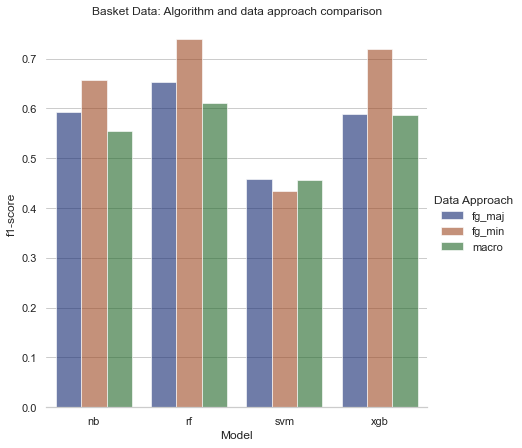

In [28]:
sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=df_comb, kind="bar",
    x="model", y="f1-score", hue="data_approach",
    ci="sd", palette="dark", alpha=.6, height=6
)
g.despine(left=True)
g.set_axis_labels("Model")
plt.title('Basket Data: Algorithm and data approach comparison')
g.legend.set_title("Data Approach")

### Parameters of best models

In [30]:
# load the model from disk
filename = "models/best_models_1month/xgb_best_model_xgb_fg_min.pickle"

best_model_overall = pickle.load(open(filename, 'rb'))
best_model_overall.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 0.1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0.3,
 'gpu_id': -1,
 'importance_type': 'gain',
 'interaction_constraints': '',
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 10,
 'min_child_weight': 1,
 'missing': nan,
 'monotone_constraints': '()',
 'n_estimators': 3000,
 'n_jobs': 6,
 'num_parallel_tree': 1,
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'subsample': 1,
 'tree_method': 'exact',
 'validate_parameters': 1,
 'verbosity': None}

### Variable Importance

In [31]:
# load the model from disk
filename = "models/best_models_1month/xgb_best_model_xgb_fg_min.pickle"

best_model_overall = pickle.load(open(filename, 'rb'))

feature_names_min = df_DR_baskets_min_fg.iloc[:, 1:-2].columns

feat_imp = best_model_overall.feature_importances_

df_feature_imp = pd.DataFrame(feat_imp, feature_names_min)
df_feature_imp.columns = ['imp']

df_feature_imp

,imp
Asian dishes,0.000000
Avocado,0.007095
Baby food,0.000000
Baking ingredients,0.006435
Bars,0.000000
...,...
Vegetables cooked (incl. cans),0.009381
Vegetarian meat alternatives,0.012607
Water-based ice,0.000000
Yeast,0.018547


<AxesSubplot:xlabel='imp'>

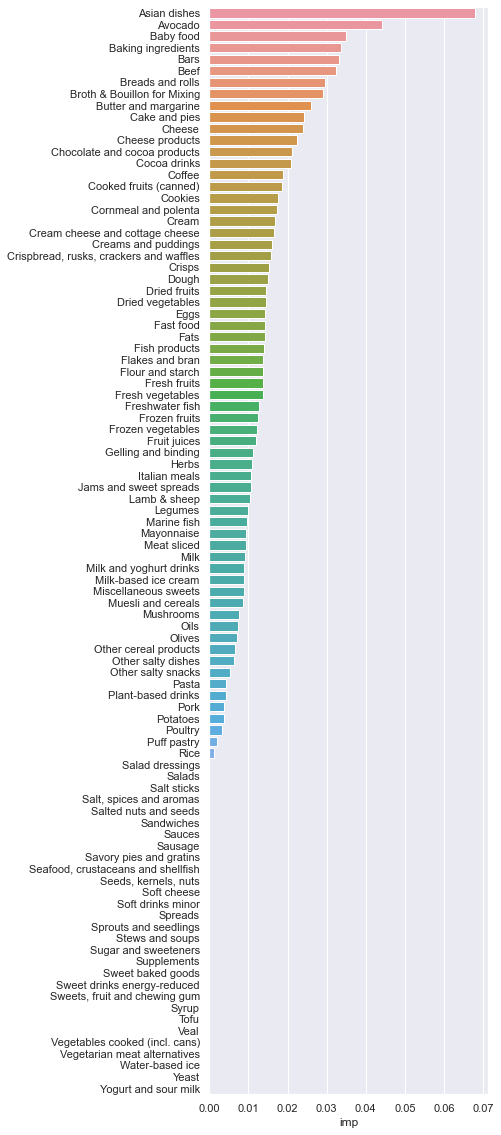

In [32]:
sns.set(rc={'figure.figsize':(5,20)})

sns.barplot(y=df_feature_imp.index, x="imp", data=df_feature_imp.sort_values(by="imp", ascending=False))